In [3]:
from vnstock import *
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Input, Conv1D, Flatten # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Model
from datetime import timedelta
from keras.utils import plot_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1. Load data from vnstock

In [4]:
end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)

df = stock_historical_data(symbol = 'CTG', start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'), resolution='1D')
df = df[['time', 'close']]
df['time'] = pd.to_datetime(df['time'])
df.rename(columns={'close': 'CTG'}, inplace=True)
df.set_index('time', inplace=True)
df

,CTG
time,
2014-06-26,8610
2014-06-27,8610
2014-06-30,8560
2014-07-01,8610
2014-07-02,8560
...,...
2024-06-17,32750
2024-06-18,32350
2024-06-19,32500


## 2.EDA

In [5]:
df.describe()

,CTG
count,2496.000000
mean,18383.687901
std,7634.877348
min,8080.000000
25%,12000.000000
50%,15420.000000
75%,25510.000000
max,36840.000000


### Outliers checking

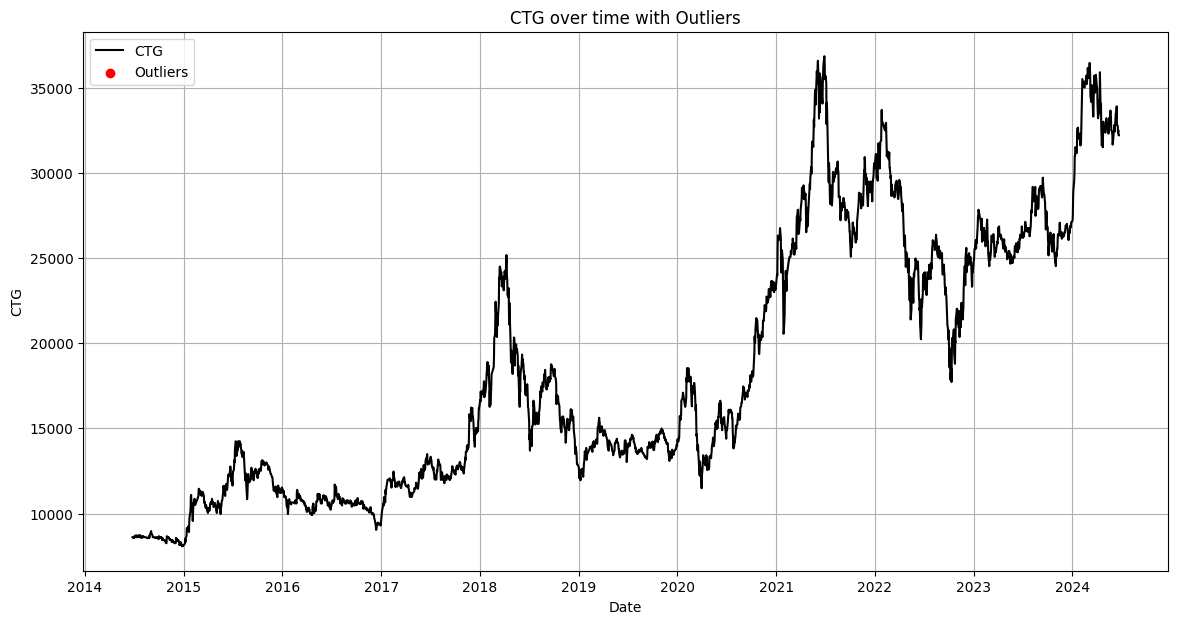

In [6]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1

outliers = df[
    (df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))
]

plt.figure(figsize=(14,7))
plt.plot(df, color = 'black', label = 'CTG')
plt.scatter(outliers.index, outliers, color = 'red', label = 'Outliers')
plt.xlabel('Date')
plt.ylabel('CTG')
plt.title('CTG over time with Outliers')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

### Histogram

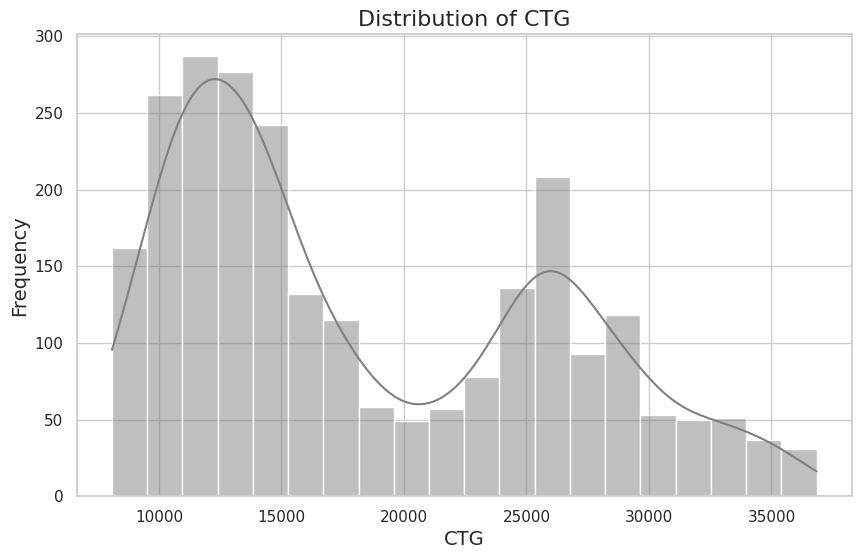

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df['CTG'], kde=True, color='grey', bins=20)
plt.title('Distribution of CTG', fontsize=16)
plt.xlabel('CTG', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

### Decomposition

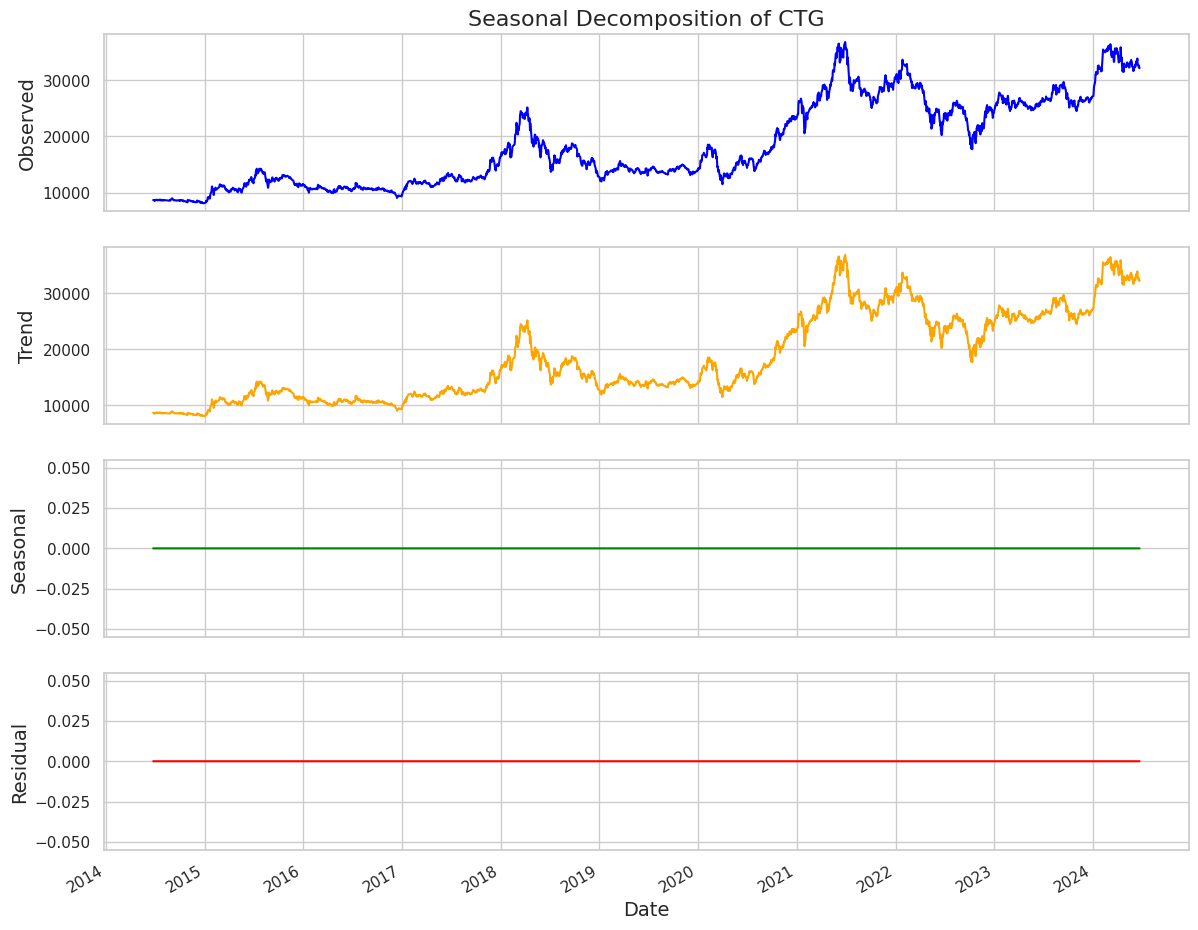

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, model='additive', period=1)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
result.observed.plot(ax=ax1, color='blue')
ax1.set_ylabel('Observed', fontsize=14)
ax1.set_title('Seasonal Decomposition of CTG', fontsize=16)
result.trend.plot(ax=ax2, color='orange')
ax2.set_ylabel('Trend', fontsize=14)
result.seasonal.plot(ax=ax3, color='green')
ax3.set_ylabel('Seasonal', fontsize=14)
result.resid.plot(ax=ax4, color='red')
ax4.set_ylabel('Residual', fontsize=14)
ax4.set_xlabel('Date', fontsize=14)
plt.show()

### Daily returns

In [ ]:
ret = df.pct_change().dropna()
ret

,CTG
time,
2014-06-26,-0.006920
2014-06-27,0.000000
2014-06-30,-0.005807
2014-07-01,0.005841
2014-07-02,-0.005807
...,...
2024-06-17,-0.001524
2024-06-18,-0.012214
2024-06-19,0.004637


### Stationary check using ADF-test

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(ret['CTG'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -34.90346919583822
p-value: 0.0
Critial Values:
   1%, -3.4329747166494915
Critial Values:
   5%, -2.862699584647827
Critial Values:
   10%, -2.567387292022104


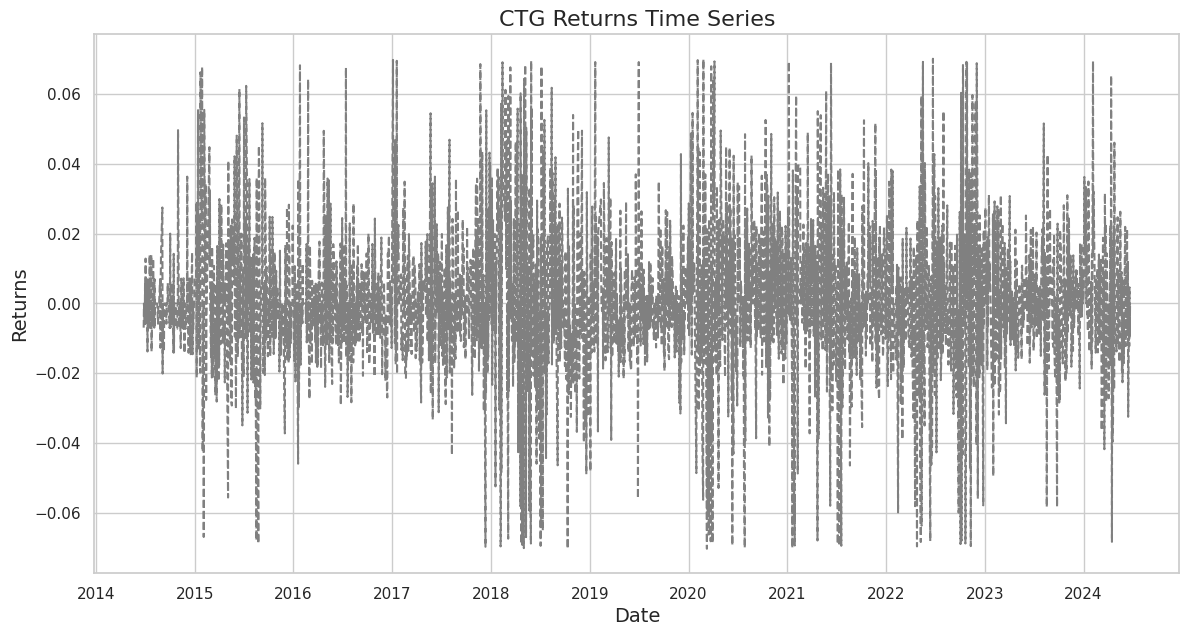

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
plt.plot(ret, color='grey', linestyle='dashed')
plt.title('CTG Returns Time Series', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)
plt.grid(True)
plt.show()

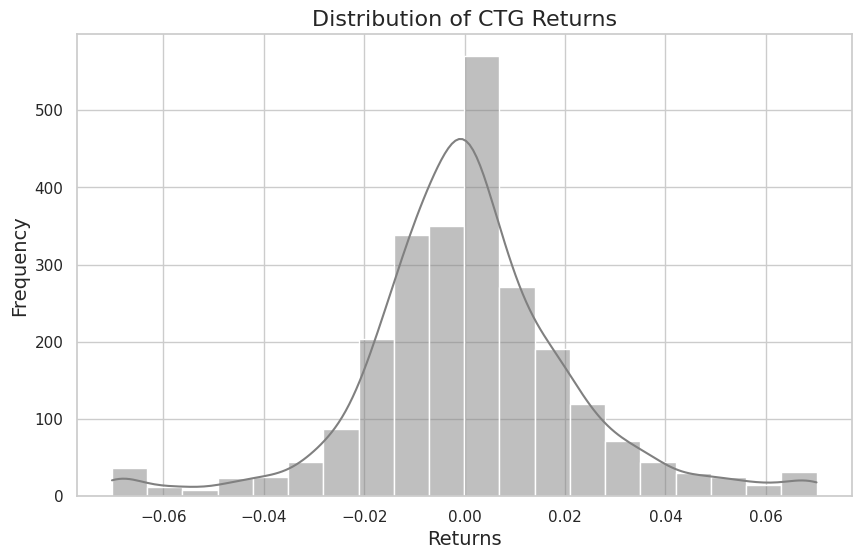

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(ret['CTG'], kde=True, color='grey', bins=20)
plt.title('Distribution of CTG Returns', fontsize=16)
plt.xlabel('Returns', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

### Stationary check using ACF and PACF

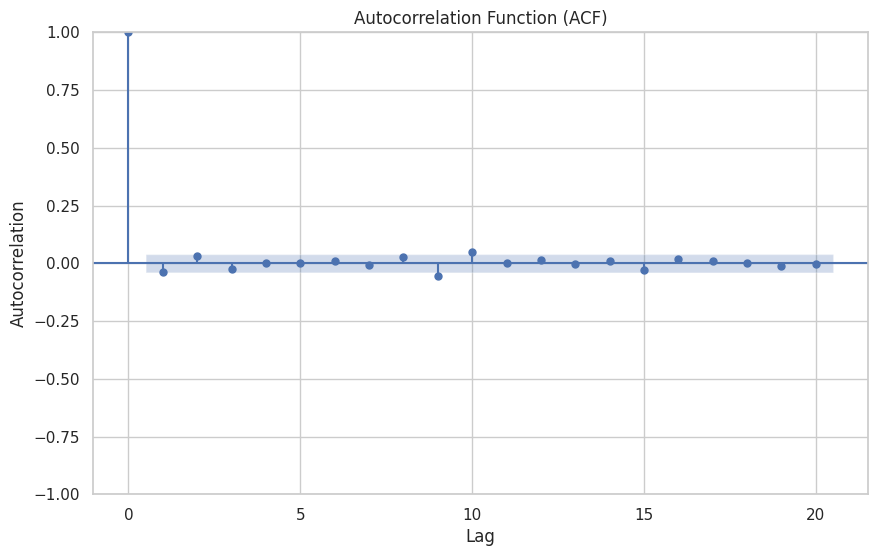

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(ret, ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

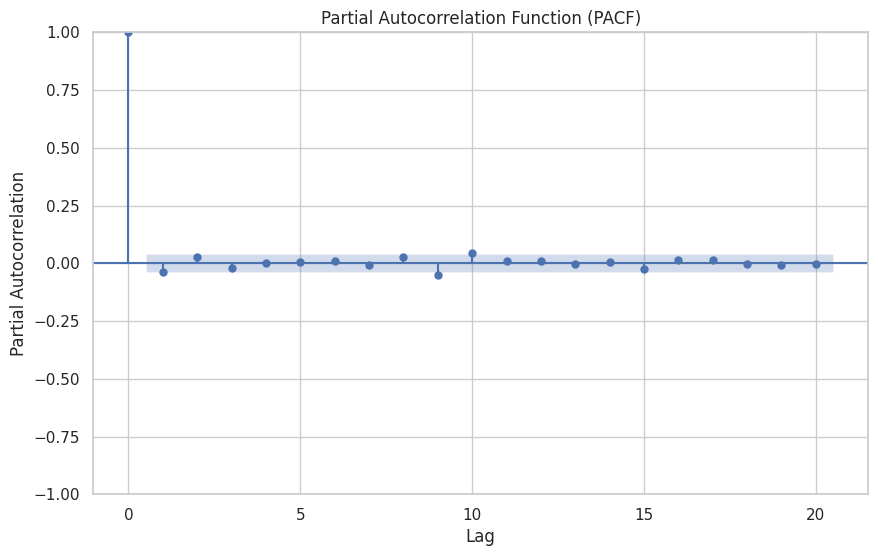

In [ ]:
plt.figure(figsize=(10, 6))
plot_pacf(ret, ax=plt.gca(), lags=20, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

## 3. Traditional technical analysis

In [ ]:
new_df = df.copy()
new_df

,CTG
time,
2014-06-25,8670
2014-06-26,8610
2014-06-27,8610
2014-06-30,8560
2014-07-01,8610
...,...
2024-06-17,32750
2024-06-18,32350
2024-06-19,32500


### SMA

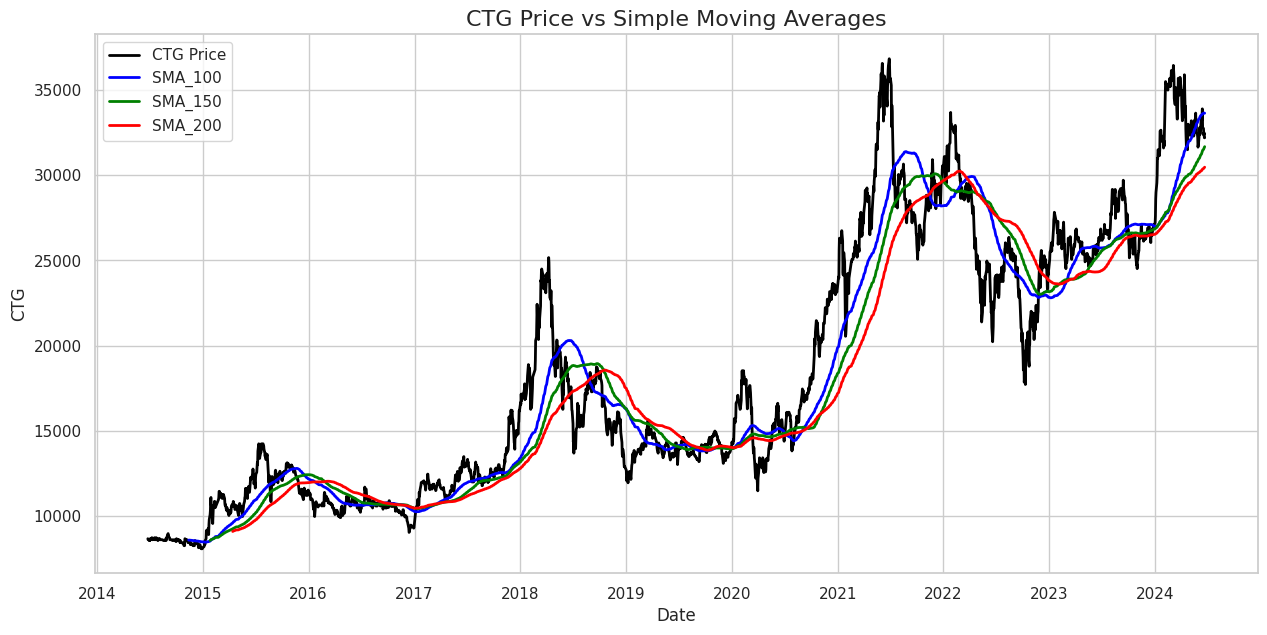

In [ ]:
window_sizes = [100, 150, 200]
for window in window_sizes:
    new_df[f'SMA_{window}'] = new_df['CTG'].rolling(window=window).mean()

plt.figure(figsize=(15, 7))
plt.plot(new_df['CTG'], label='CTG Price', color='black', linewidth=2)
colors = ['blue', 'green', 'red']
for idx, window in enumerate(window_sizes):
    plt.plot(new_df[f'SMA_{window}'], label=f'SMA_{window}', color=colors[idx], linewidth=2)
plt.xlabel('Date')
plt.ylabel('CTG')
plt.title('CTG Price vs Simple Moving Averages', fontsize=16)
plt.legend(loc= 'best')
plt.grid(True)
plt.show()

### EMA

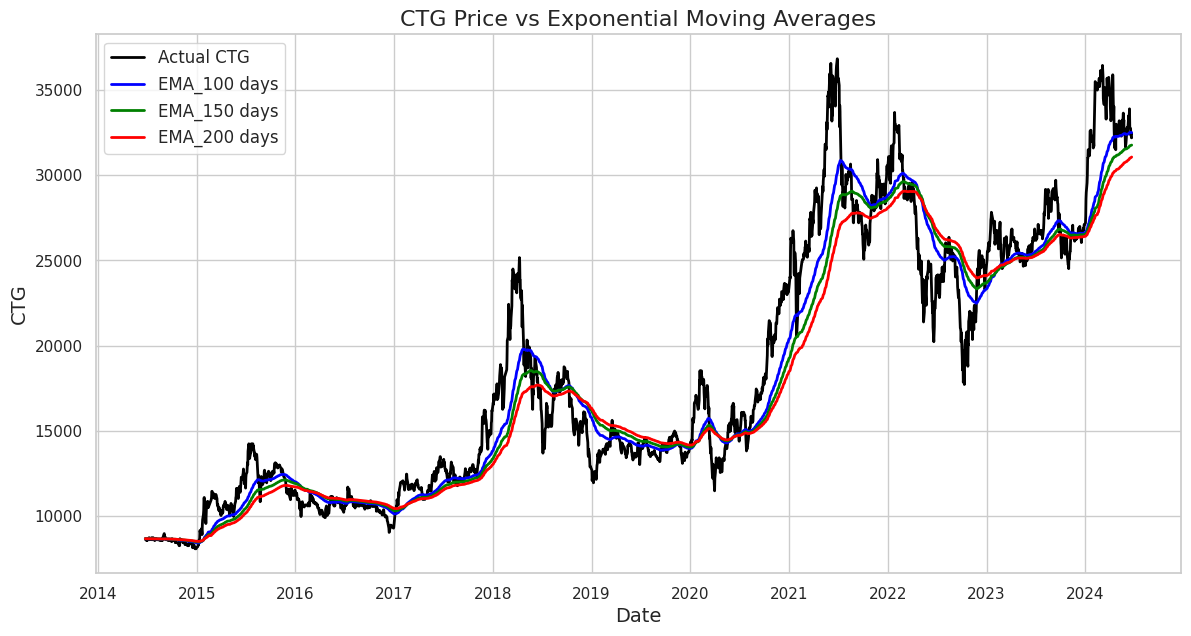

In [ ]:
time_periods = [100, 150, 200]
for period in time_periods:
    new_df[f'EMA_{period}'] = new_df['CTG'].ewm(span=period, adjust=False).mean()

plt.figure(figsize=(14, 7))
plt.plot(new_df['CTG'], label='Actual CTG', color='black', linewidth=2)
colors = ['blue', 'green', 'red']
for idx, period in enumerate(time_periods):
    plt.plot(new_df[f'EMA_{period}'], label=f'EMA_{period} days', color=colors[idx], linewidth=2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('CTG', fontsize=14)
plt.title('CTG Price vs Exponential Moving Averages', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## 4. Prediction using Diluted-CNN-seq2seq model

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Data preparation for dilated CNN
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Choose a sequence length (number of time steps to look back)
seq_length = 5
X, y = create_sequences(scaled_data, seq_length)

# Reshape X to be 3-dimensional [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
split = int(len(df) * 0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [ ]:
def create_model(filters=64, kernel_size=2, dilation_rate=2, optimizer='adam'):
    input_layer = Input(shape=(seq_length, 1))
    conv_layer = Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, activation='relu')(input_layer)
    flatten_layer = Flatten()(conv_layer)
    output_layer = Dense(1)(flatten_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Build the model
model = create_model()

model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 5, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

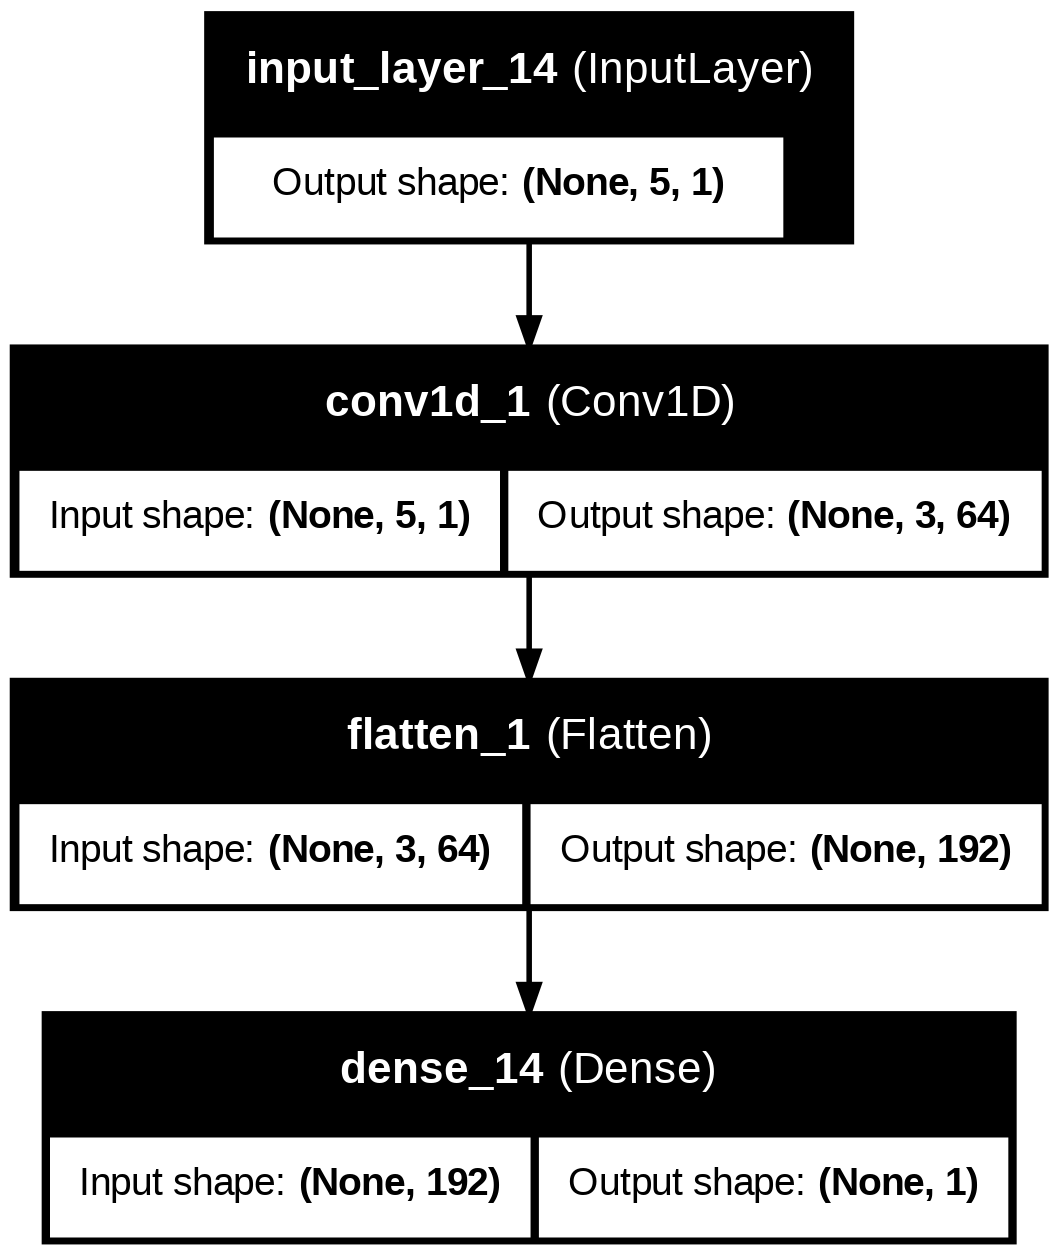

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

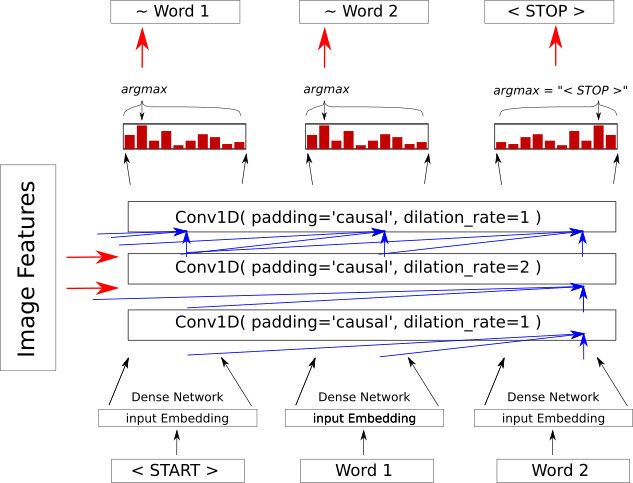

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=150, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0491 - val_loss: 0.0693
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0269
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0858e-04 - val_loss: 0.0059
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5985e-04 - val_loss: 0.0035
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4963e-04 - val_loss: 0.0036
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4577e-04 - val_loss: 0.0030
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4040e-04 - val_loss: 0.0029
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4129e-04 - val_loss: 0.0026
Epoch 9/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3027e-04 - val_loss: 0.0023
Epoch 10/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3933e-04 - val_loss: 0.0023
Epoch 11/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1345e-04 - val_loss: 0.0025
Epoch 12/150
50/50 ━━━━━━━

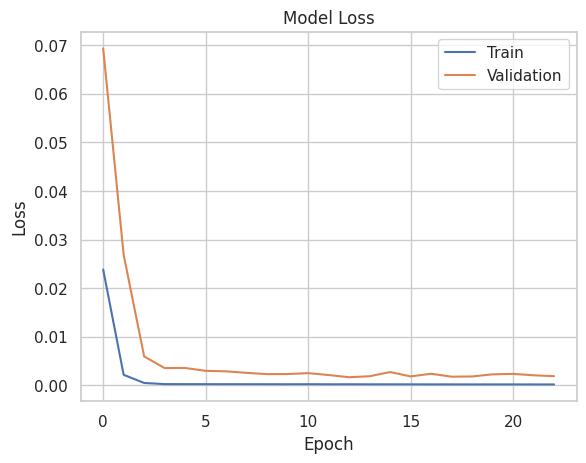

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


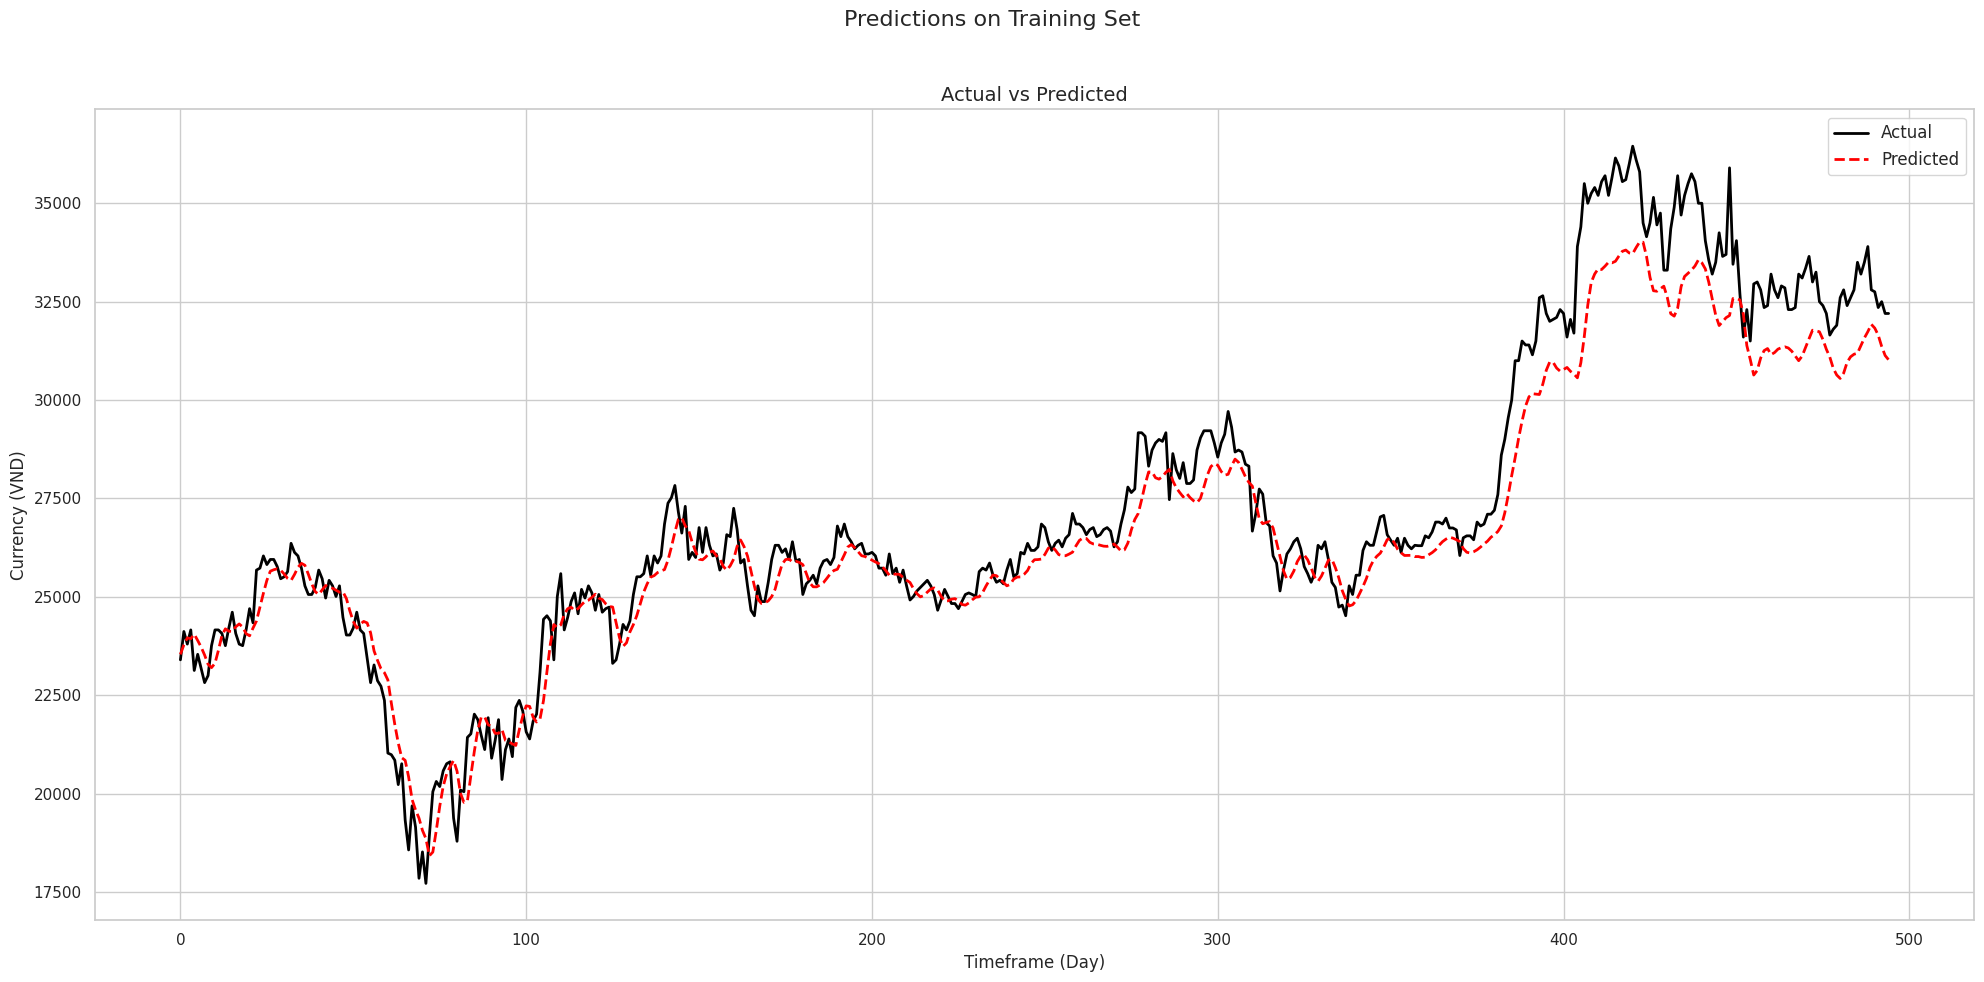

In [ ]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred)

plt.figure(figsize=(20, 10))

plt.plot(y_test_inverse, label='Actual', color='black', linestyle='-', linewidth=2)
plt.plot(y_pred_inverse, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted', fontsize=14)
plt.xlabel('Timeframe (Day)', fontsize=12)
plt.ylabel('Currency (VND)', fontsize=12)
plt.grid(True)
plt.legend(loc='best', fontsize=12)

plt.suptitle('Predictions on Training Set', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
def calculate_series_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    non_zero_indices = y_true != 0
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]

    percentage_diff = np.abs((y_true - y_pred) / y_true) * 100
    accuracy = 100 - np.mean(percentage_diff)

    return accuracy

accuracy = calculate_series_accuracy(y_test_inverse, y_pred_inverse)
print(f"Prediction Accuracy: {accuracy:.2f}%")

Prediction Accuracy: 97.30%


In [ ]:
def build_keras_regressor(filters=64, kernel_size=2, dilation_rate=2, optimizer='adam'):
    return KerasRegressor(build_fn=create_model,
                          filters=filters,
                          kernel_size=kernel_size,
                          dilation_rate=dilation_rate,
                          optimizer=optimizer,
                          verbose=0)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

seed = 10
np.random.seed(seed)

param_grid = {
    'filters': [32, 64],
    'kernel_size': [2, 3],
    'dilation_rate': [1, 2],
    'optimizer': ['adam'],
    'batch_size': [32, 64],
    'epochs': [50, 100, 150]
}

grid = GridSearchCV(estimator=build_keras_regressor(), param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

grid_result = grid.fit(X_train, y_train, callbacks=[early_stopping])
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"{mean:.2f} ({std:.2f}) with: {param}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.9836340319995328 using {'batch_size': 32, 'dilation_rate': 1, 'epochs': 150, 'filters': 64, 'kernel_size': 3, 'optimizer': 'adam'}
0.97 (0.02) with: {'batch_size': 32, 'dilation_rate': 1, 'epochs': 50, 'filters': 32, 'kernel_size': 2, 'optimizer': 'adam'}
0.97 (0.01) with: {'batch_size': 32, 'dilation_rate': 1, 'epochs': 50, 'filters': 32, 'kernel_size': 3, 'optimizer': 'adam'}
0.95 (0.03) with: {'batch_size': 32, 'dilation_rate': 1, 'epochs': 50, 'filters': 64, 'kernel_size': 2, 'optimizer': 'adam'}
0.98 (0.00) with: {'batch_size': 32, 'dilation_rate': 1, 'epochs': 50, 'filters': 64, 'kernel_size': 3, 'optimizer': 'adam'}
0.98 (0.01) with: {'batch_size': 32, 'dilation_rate': 1, 'epochs': 100, 'filters': 32, 'kernel_size': 2, 'optimizer': 'adam'}
0.97 (0.02) with: {'batch_size': 32, 'dilation_rate': 1, 'epochs': 100, 'filters': 32, 'kernel_size': 3, 'optimizer': 'adam'}
0.98 (0.01) with: {'batch_size': 32, 'dilation_rate': 1, 'epochs': 100, 'filters': 64, 'kernel_size': 2, 'opt

In [ ]:
best_params = grid_result.best_params_

best_model = create_model(
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dilation_rate=best_params['dilation_rate'],
    optimizer=best_params['optimizer']
)

history = best_model.fit(X_train, y_train,
                         validation_split=0.2,
                         epochs=best_params['epochs'],
                         batch_size=best_params['batch_size'],
                         callbacks=[early_stopping],
                         verbose=1)

Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0245 - val_loss: 0.0151
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.4614e-04 - val_loss: 0.0048
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3539e-04 - val_loss: 0.0039
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4449e-04 - val_loss: 0.0035
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4037e-04 - val_loss: 0.0032
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2102e-04 - val_loss: 0.0029
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4701e-04 - val_loss: 0.0026
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2308e-04 - val_loss: 0.0031
Epoch 9/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2261e-04 - val_loss: 0.0027
Epoch 10/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0305e-04 - val_loss: 0.0023
Epoch 11/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8934e-04 - val_loss: 0.0023
Epoch 12/150
50/50 ━━━

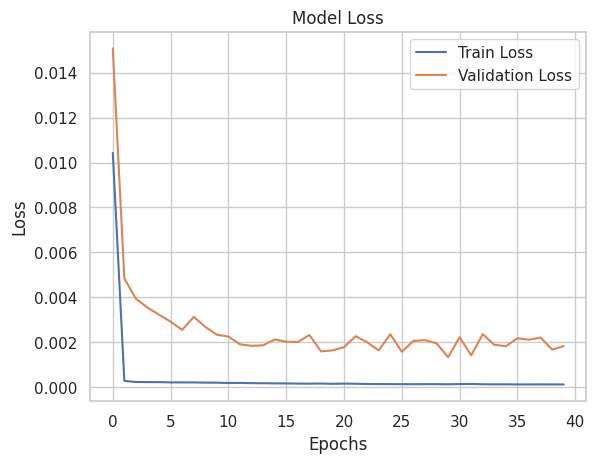

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = best_model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred)

accuracy = calculate_series_accuracy(y_test_inverse, y_pred_inverse)
print(f"Prediction Accuracy: {accuracy:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction Accuracy: 97.62%


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


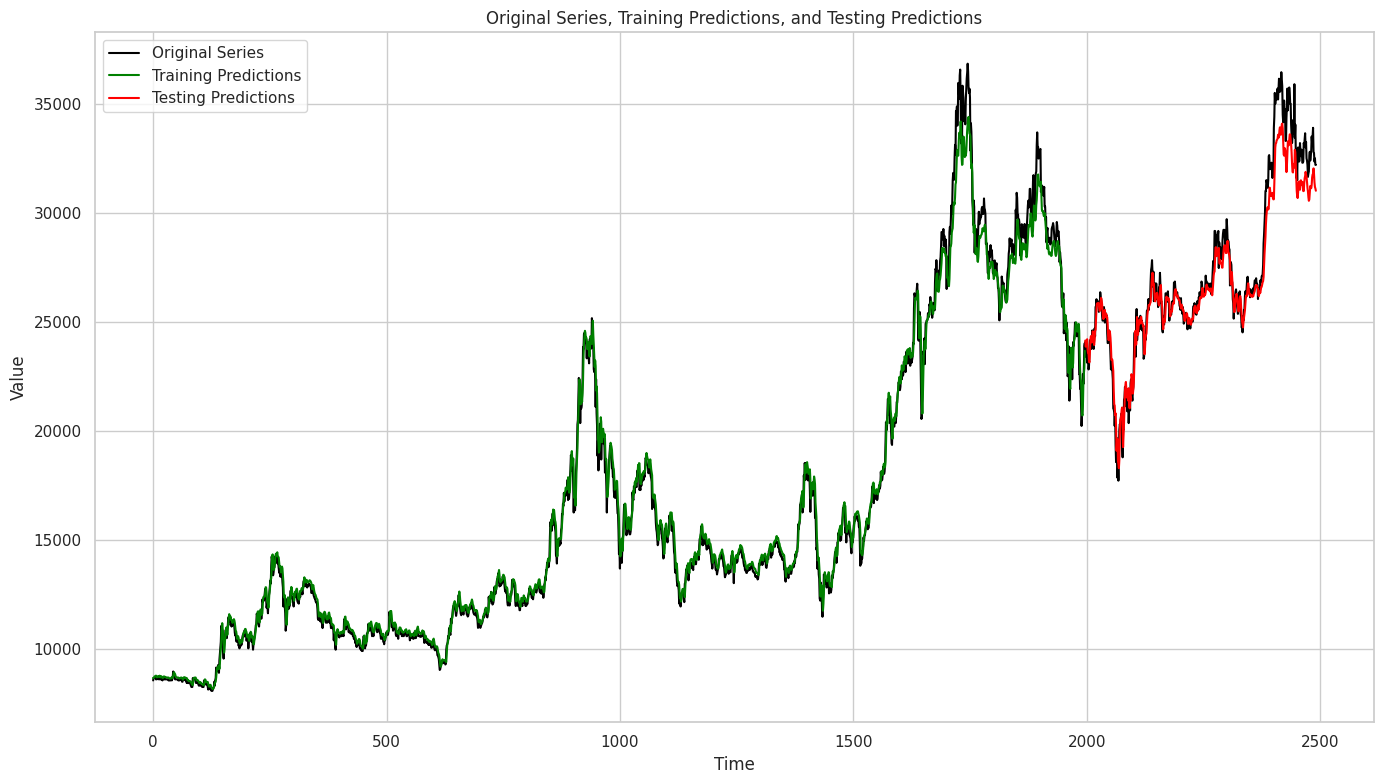

In [ ]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

y_train_pred_inverse = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred_inverse = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

original_series = np.concatenate((y_train_inverse, y_test_inverse))
predicted_series = np.concatenate((y_train_pred_inverse, y_test_pred_inverse))

plt.figure(figsize=(14, 8))

plt.plot(original_series, label='Original Series', color='black')
plt.plot(range(len(y_train_pred_inverse)), y_train_pred_inverse, label='Training Predictions', color='green')
plt.plot(range(len(y_train_pred_inverse), len(y_train_pred_inverse) + len(y_test_pred_inverse)), y_test_pred_inverse, label='Testing Predictions', color='red')
plt.title('Original Series, Training Predictions, and Testing Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Trading strategy and backtesting

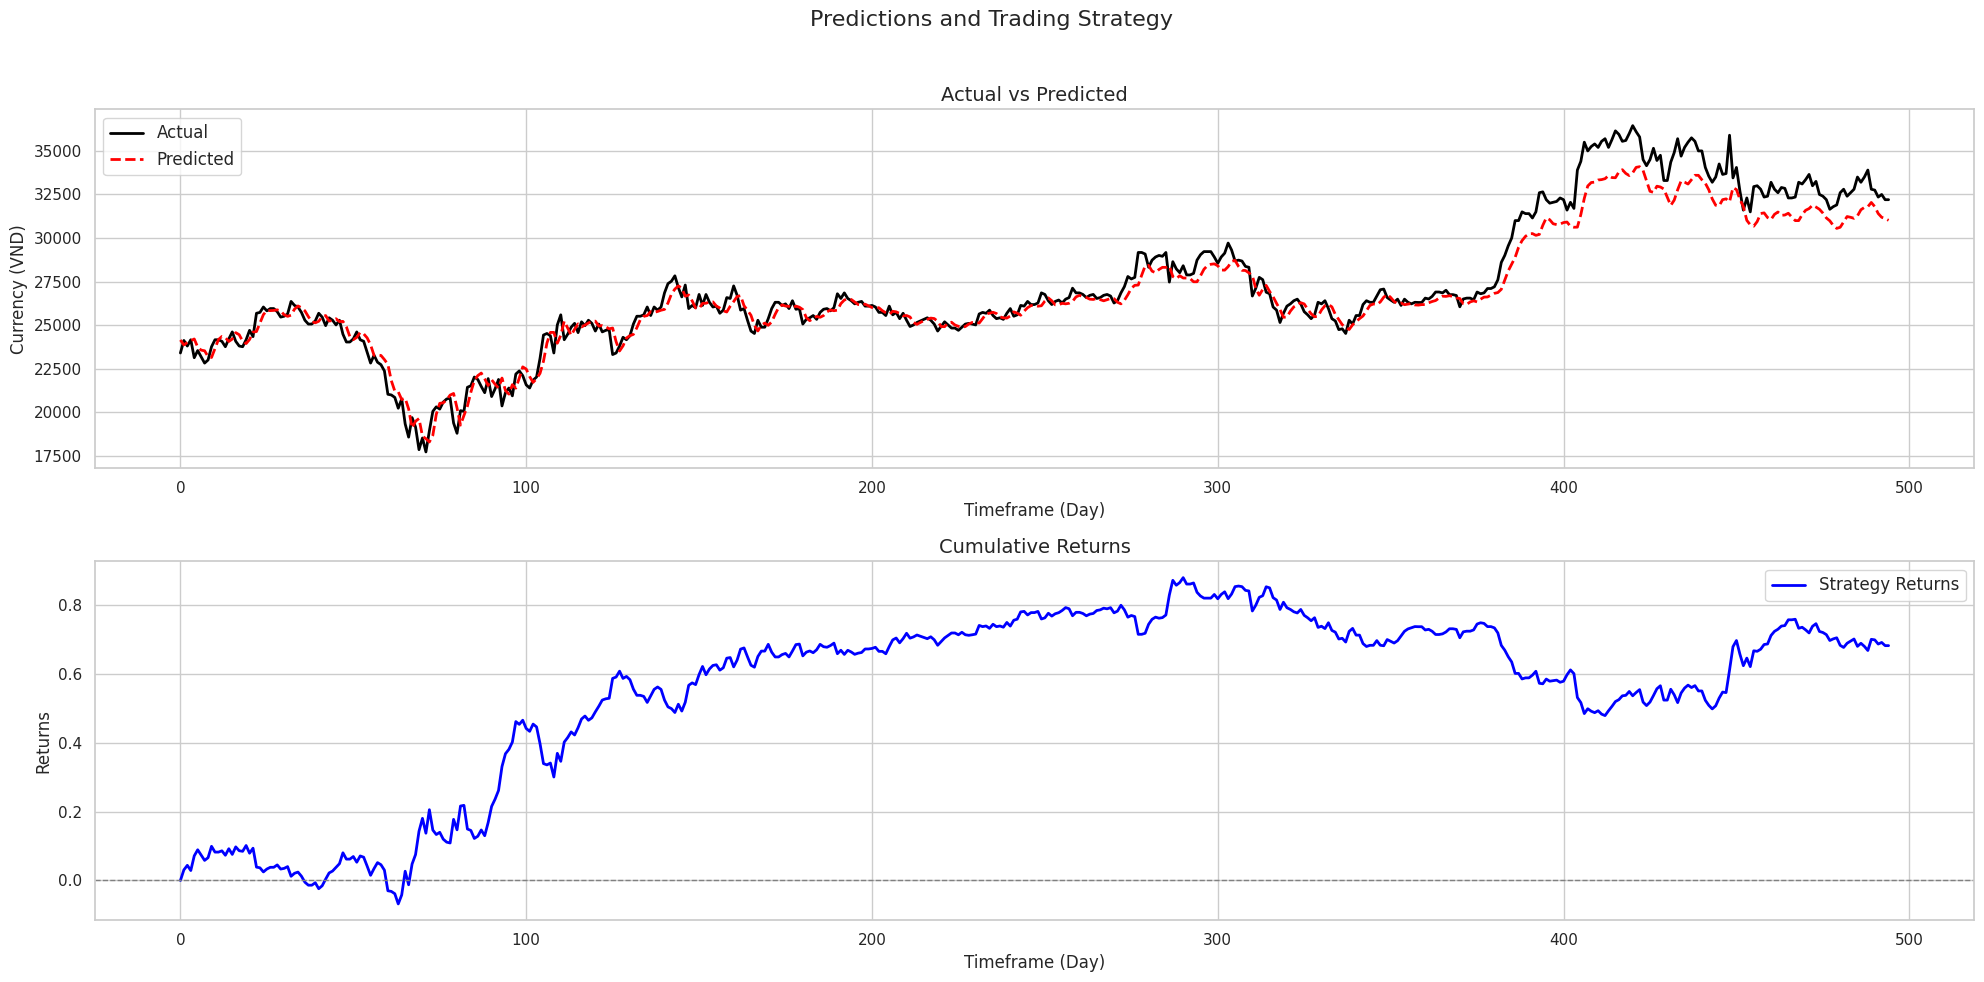

In [ ]:
signals = np.zeros_like(y_pred_inverse)
signals[1:] = np.sign(y_pred_inverse[1:] - y_pred_inverse[:-1])

daily_returns = np.zeros_like(y_pred_inverse)
daily_returns[1:] = signals[1:] * (y_test_inverse[:-1] - y_test_inverse[1:]) / y_test_inverse[:-1]

cumulative_returns = np.cumsum(daily_returns)
portfolio_value = np.cumprod(1 + daily_returns)
previous_peaks = np.maximum.accumulate(portfolio_value)
drawdowns = (portfolio_value - previous_peaks) / previous_peaks
max_drawdown = np.max(drawdowns)

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(y_test_inverse, label='Actual', color='black', linestyle='-', linewidth=2)
plt.plot(y_pred_inverse, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted', fontsize=14)
plt.xlabel('Timeframe (Day)', fontsize=12)
plt.ylabel('Currency (VND)', fontsize=12)
plt.grid(True)
plt.legend(loc='best', fontsize=12)

plt.subplot(2, 1, 2)
plt.plot(cumulative_returns, label='Strategy Returns', color='blue', linestyle='-', linewidth=2)
plt.title('Cumulative Returns', fontsize=14)
plt.xlabel('Timeframe (Day)', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.grid(True)
plt.legend(loc='best', fontsize=12)

plt.suptitle('Predictions and Trading Strategy', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
returns = cumulative_returns[-1]
num_years = len(y_test_inverse) / 252
annualized_returns = (1 + returns)**(1 / num_years) - 1
sharpe_ratio = np.sqrt(252) * np.mean(daily_returns) / np.std(daily_returns)

max_drawdown = 0.0
peak_value = portfolio_value[0]
trough_value = portfolio_value[0]

for i in range(1, len(portfolio_value)):
    if portfolio_value[i] > peak_value:
        peak_value = portfolio_value[i]
    else:
        drawdown = (peak_value - portfolio_value[i]) / peak_value
        if drawdown > max_drawdown:
            max_drawdown = drawdown
            trough_value = portfolio_value[i]

In [ ]:
print(f"Annualized Returns: {annualized_returns:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Annualized Returns: 30.35%
Sharpe Ratio: 1.07
Maximum Drawdown: 34.08%
